# Segmentez des clients d'un site e-commerce

- **Projet 5 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Partie 1 : Nettoyage et analyse exploratoire des données

<img  width="76" height="30" src="https://olist.com/wp-custom/themes/olist20/assets/img/brand.svg" alt="Logo olist">


<!--TABLE OF CONTENTS-->

- [1. Compréhension du problème](#1.-Compréhension-du-problème)
  - [1.1 Mission](#1.1-Mission)
  - [1.2 Requirements : Bibliothèques utilisées dans ce notebook](#1.2-Requirements-:-Bibliothèques-utilisées-dans-ce-notebook)
  - [1.3 Des fonctions utilitaires](#1.3-Des-fonctions-utilitaires)
  - [1.4 Des routines statistiques](#1.4-Des-routines-statistiques)
- [2. Import et nettoyage des données](#2.-Import-et-nettoyage-des-données)
  - [2.1 Description des données (metadata)](<#2.1-Description-des-données-(metadata)>)
  - [2.2 Import des données](#2.2-Import-des-données)
  - [2.3 Description de données (après import)](<#2.3-Description-de-données-(après-import)>)
  - [2.4 Nettoyage des données](#2.4-Nettoyage-des-données)
- [3. Analyse Exploratoire](#3.-Analyse-Exploratoire)
  - [3.1 Données numériques](#3.1-Données-numériques)
  - [3.2 Données catégoriques](#3.2-Données-catégoriques)
  - [3.3 Associations entre variables catégoriques et numériques](#3.3-Associations-entre-variables-catégoriques-et-numériques)
- [4. Feature Engineering](#4.-Feature-Engineering)
  - [4.1 Nouvelles 'features' catégoriques](#4.1-Nouvelles-'features'-catégoriques)
  - [4.2 Nouvelles 'features' numériques](#4.2-Nouvelles-'features'-numériques)
- [5. Enregistrement des données nettoyées](#5.-Enregistrement-des-données-nettoyées)
  - [5.1 Sommaire des données nettoyées](#5.1-Sommaire-des-données-nettoyées)


# 1. Compréhension du problème

## 1.1 Mission

[Olist](https://olist.com/), une entreprise brésilienne qui propose une solution de vente sur les
marketplaces en ligne, souhaite une **segmentation des clients** que ses équipes d'e-commerce pourront
utiliser au quotidien pour leurs campagnes de communication.

- **comprendre les différents types d'utilisateurs**, grâce à leur comportement et à leurs données
  personnelles, en regroupant des clients de profils similaires. Ces catégories pourront être
  utilisées par l’équipe Marketing pour mieux communiquer.

- **fournir à l’équipe marketing une description actionable** de votre segmentation et de sa logique
  sous-jacente pour une utilisation optimale

- **une proposition de contrat de maintenance**, (fréquence à laquelle la segmentation doit être
  mise à jour pour rester pertinente), basée sur une analyse de la stabilité des segments au cours
  du temps.


### Objectives d'analyse exploratoire

- Connaitre les données
- Nettoyer les données
- Identifier les indicateurs actionable
- Créer des nouvelles features / indicateurs si besoin


## 1.2 Requirements : Bibliothèques utilisées dans ce notebook

- voir [`requirements.txt`](./requirements.txt) pour les versions des bibliothèques testées avec ce notebook


In [1]:
# si ce notebook ne marche pas avec les versions
# des bibliothèques dans votre environnement, alors
# decommentarise la ligne suivant pour des versions testées:

# %pip install -r requirements.txt


In [2]:
def install_libraries(required={}) -> None:
    """
    Installation des bibliothèques manquantes
    https://stackoverflow.com/questions/44210656/
    """
    import sys
    import subprocess
    import pkg_resources
    installed = {pkg.key for pkg in pkg_resources.working_set}
    missing = set(required) - set(installed)
    if missing:
        print(f'missing libraries: {missing}')
        python = sys.executable
        subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                              stdout=subprocess.DEVNULL)


required_libraries = {'numpy', 'pandas', 'matplotlib', 'seaborn',
                      'scipy', 'scikit-learn', 'statsmodels',
                      'missingno', 'dython'}
install_libraries(required_libraries)


### 1.2.1 Import des bibliothèques


In [3]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import missingno as msno
import sklearn
import dython
# pour calculer VIF -Variance Influence Factor
from sklearn.linear_model import LinearRegression
# correlations catégoriques (Cramers V, Theils U)
from dython.nominal import associations


### 1.2.2 Liste des versions des bibliothèques utilisées


In [4]:
from platform import python_version

python_version()
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


versions des bibliothèques utilisées:
json==2.0.9; numpy==1.21.5; pandas==1.1.5; seaborn==0.11.2; scipy==1.7.3; missingno==0.5.0; sklearn==1.0.2; dython==0.6.8


### 1.2.3 Configuration défauts d'affichage


In [5]:
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 10)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 800)  # pour afficher toutes la text
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.3f}'.format

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")


## 1.3 Des fonctions utilitaires

### 1.3.1 Enregistrement des graphiques

Pour enregistrer les graphiques, define **`SAVE_IMAGES = True`**


In [6]:
SAVE_IMAGES = True
IMAGE_FOLDER = './images/notebook'
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)


In [7]:
def to_png(fig_name=None) -> None:
    """
    Enregistre l'image dans un fichier,
    il faut appeler avant plt.show() pour pouvoir ajuster la taille de l'image
    avec bbox_inches=tight pour être sûr d'inclure le titre / legend entier.
    """

    def get_title():
        if plt.gcf()._suptitle is None:  # noqa
            return plt.gca().get_title()
        else:
            return plt.gcf()._suptitle.get_text()  # noqa

    if SAVE_IMAGES:
        if fig_name is None:
            fig_name = get_title()
        elif len(fig_name) < 9:
            fig_name = f'{fig_name}_{get_title()}'
        fig_name = fig_name.replace(' ', '_').replace(':', '-').replace(
            '.', '-').replace('/', '_').replace('>', 'gt.').replace('<', 'lt.')
        print(f'"{fig_name}.png"')
        plt.gcf().savefig(
            f'{IMAGE_FOLDER}/{fig_name}.png', bbox_inches='tight')


### 1.3.2 Vérifier que les colonnes sont dans le dataframe

- sans changer l'ordre des colonnes


In [8]:
def cols_in_df(df: pd.DataFrame, colonnes: list = None) -> list:
    """Procedure pour retourner les colonnes existantes dans le dataframe dans la même ordre.
    Utiliser pour assurer que les colonnes existe.
    """
    ret_cols = []
    for col in colonnes:
        if col in df.columns:
            ret_cols.append(col)
    return ret_cols


# 2. Import et nettoyage des données

Olist a fournit une [base de données](https://www.kaggle.com/olistbr/brazilian-ecommerce) anonymisée
comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de
satisfaction, et la localisation des clients depuis janvier 2017.


## 2.1 Description des données (metadata)

Le data schema et déscription des champs sont fournis à la même [adresse](https://www.kaggle.com/olistbr/brazilian-ecommerce) que les données:

<img width="564" height="339" alt="Data Schema" src="https://i.imgur.com/HRhd2Y0.png">


## 2.2 Import des données


In [9]:
DATA_DIR = 'data/raw'


def load_dataset(set_name='customers'):
    filename = f'{DATA_DIR}/olist_{set_name}_dataset.csv'
    df = pd.read_csv(filename)
    print(f'{set_name}.shape = {df.shape}; columns : {list(df.columns)}')
    return df


customers = load_dataset('customers')

customers.head()


customers.shape = (99441, 5); columns : ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


## Chargé les autres datasets


In [10]:
geolocation = load_dataset('geolocation')
order_items = load_dataset('order_items')
order_payments = load_dataset('order_payments')
order_reviews = load_dataset('order_reviews')
orders = load_dataset('orders')
products = load_dataset('products')
sellers = load_dataset('sellers')
product_category_names = pd.read_csv(
    'data/raw/product_category_name_translation.csv')


geolocation.shape = (1000163, 5); columns : ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']
order_items.shape = (112650, 7); columns : ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
order_payments.shape = (103886, 5); columns : ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']
order_reviews.shape = (99224, 7); columns : ['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']
orders.shape = (99441, 8); columns : ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
products.shape = (32951, 9); columns : ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_ph

## 2.3 Description de données (après import)


In [11]:
def decrire_dataframe(df: pd.DataFrame):
    """Retourner un dataframe avec des informations sur les colonnes d'un dataframe"""
    print(f'{df.shape[0]} registres')
    ret = df.columns.to_frame(name="column").set_index('column')
    ret['% manquantes'] = df.isna().mean()
    ret['unique'] = df.nunique()
    ret['dtype'] = df.dtypes
    ret['min'] = df.min()
    ret['max'] = df.max()
    ret['std'] = df.std()
    return ret


### Customers


In [12]:
decrire_dataframe(customers)


99441 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
customer_id,0.000,99441,object,00012a2ce6f8dcda20d059ce98491703,ffffe8b65bbe3087b653a978c870db99,nan
customer_unique_id,0.000,96096,object,0000366f3b9a7992bf8c76cfdf3221e2,ffffd2657e2aad2907e67c3e9daecbeb,nan
customer_zip_code_prefix,0.000,14994,int64,1003,99990,29797.939
customer_city,0.000,4119,object,abadia dos dourados,zortea,nan
customer_state,0.000,27,object,AC,TO,nan


#### Combien de clients ont plus d'un 'customer_id'?


In [13]:
customers[['customer_id', 'customer_unique_id']].groupby(
    'customer_unique_id').agg('count').value_counts()


customer_id
1              93099
2               2745
3                203
4                 30
5                  8
6                  6
7                  3
17                 1
9                  1
dtype: int64

#### Qualité des données customer

- 100% remplis
- utilise 'customer_unique_id' pour identifier chaque client, car environ 3000 clients ont plusieurs 'customer_id'
- besoin de merge avec **geolocation** pour savoir la localisation des clients


### Geolocation


In [14]:
decrire_dataframe(geolocation)


1000163 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
geolocation_zip_code_prefix,0.000,19015,int64,1001,99990,30549.336
geolocation_lat,0.000,717358,float64,-36.605,45.066,5.716
geolocation_lng,0.000,717613,float64,-101.467,121.105,4.270
geolocation_city,0.000,8011,object,* cidade,óleo,nan
geolocation_state,0.000,27,object,AC,TO,nan


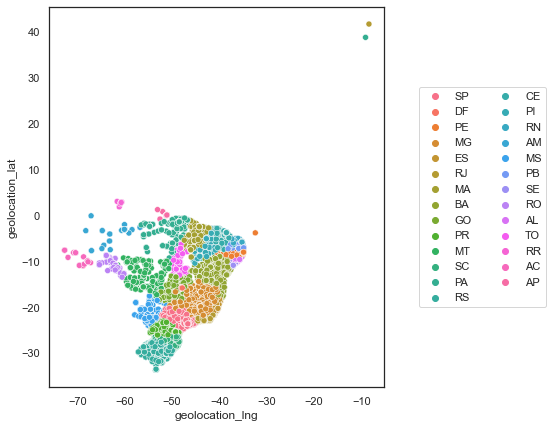

In [15]:
plt.figure(figsize=(6, 7))
sns.scatterplot(data=geolocation.sample(50000), x='geolocation_lng',
                y='geolocation_lat', hue='geolocation_state')
plt.legend(bbox_to_anchor=(1.5, 0.5), loc=5, ncol=2)


#### Geolocation : qualité des données

- les 'states' sont 100% remplies; il y a 27 unités fédératives au brésil
- les 'city' ne sont pas toujours des vraies villes
- les latitudes ne sont pas toujours en brésil ([5°16'20" Nord à 33°44'32" Sud de latitude](https://fr.wikipedia.org/wiki/G%C3%A9ographie_du_Br%C3%A9sil#Situation_et_%C3%A9tendue))
- les longitudes ne sont pas toujours en brésil ([34°47'30" Ouest à 73°59'32" Ouest de longitude](https://fr.wikipedia.org/wiki/G%C3%A9ographie_du_Br%C3%A9sil#Situation_et_%C3%A9tendue))
- Ce n'est pas clair pourquoi il y a environ 75 (lat,lng) pour chaque zip code - les zip des adresses?


#### Geolocations hors brésil


In [16]:
print('trop au nord ', geolocation[geolocation['geolocation_lat'] > 5.3].shape)
print('trop au sud ',
      geolocation[geolocation['geolocation_lat'] < -33.75].shape)
print("trop à l'est",
      geolocation[geolocation['geolocation_lng'] > -34.7].shape)
print("trop à l'ouest",
      geolocation[geolocation['geolocation_lng'] < -74].shape)

mask_lat = (geolocation['geolocation_lat'] > 5.3) | (
    geolocation['geolocation_lat'] < -33.75)
mask_lng = (geolocation['geolocation_lng'] > -
            34.7) | (geolocation['geolocation_lng'] < -74)
hors_bresil = geolocation[mask_lat | mask_lng]
hors_bresil.shape


trop au nord  (26, 5)
trop au sud  (5, 5)
trop à l'est (33, 5)
trop à l'ouest (4, 5)


(42, 5)

Eliminer les outliers de (lat,lng) dans les zipcodes


<AxesSubplot:xlabel='geolocation_lat', ylabel='geolocation_lng'>

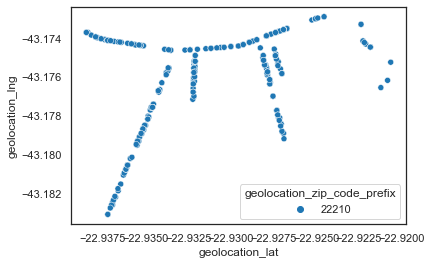

In [17]:
geolocation['geolocation_zip_code_prefix'] = geolocation['geolocation_zip_code_prefix'].astype(
    str)
flamengo = geolocation[geolocation['geolocation_zip_code_prefix'] == "22210"]
sns.scatterplot(data=flamengo, x='geolocation_lat',
                y='geolocation_lng', hue='geolocation_zip_code_prefix')


#### Créer geolocations uniques des zipcodes

Les données sont anonymisées, donc on prend la médiane des (lat,lng) pour chaque zip code, après avoir éliminé les 42 registres avec coordonées hors bresil (la mèdiane doit éliminer l'effet de quelques erreurs de lat,lng pour chaque zipcode)


In [18]:
geoloc: pd.DataFrame = (geolocation
                        .drop(hors_bresil.index)
                        .groupby(['geolocation_zip_code_prefix', 'geolocation_state'])
                        .agg({'geolocation_lat': 'median', 'geolocation_lng': 'median', 'geolocation_city': 'count'})
                        .rename(columns={'geolocation_city': 'count'})
                        .reset_index())
print(geoloc.shape)
decrire_dataframe(geoloc)


(19018, 5)
19018 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
geolocation_zip_code_prefix,0.000,19010,object,1001,99990,nan
geolocation_state,0.000,27,object,AC,TO,nan
geolocation_lat,0.000,18993,float64,-33.691,4.478,7.240
geolocation_lng,0.000,18993,float64,-72.909,-34.799,5.197
count,0.000,483,int64,1,1146,72.056


Il y a 8 zipcodes avec duplicates :


In [19]:
geoloc_dups = geoloc[geoloc.duplicated(
    keep=False, subset=['geolocation_zip_code_prefix'])]
geoloc_dups.head(8)


,geolocation_zip_code_prefix,geolocation_state,geolocation_lat,geolocation_lng,count
2475,2116,RN,-23.516,-46.582,1
2476,2116,SP,-23.519,-46.585,12
2553,21550,AC,-22.858,-43.353,1
2554,21550,RJ,-22.862,-43.354,170
2857,23056,AC,-22.919,-43.611,1
2858,23056,RJ,-22.918,-43.614,60
7253,4011,AC,-23.579,-46.646,1
7254,4011,SP,-23.580,-46.643,178


Supprime les zipcodes duplicates ou il y a moins d'entrées


In [20]:
geoloc = geoloc.sort_values(by='count', ascending=False).drop_duplicates(
    keep='first', subset='geolocation_zip_code_prefix')
decrire_dataframe(geoloc)


19010 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
geolocation_zip_code_prefix,0.000,19010,object,1001,99990,nan
geolocation_state,0.000,27,object,AC,TO,nan
geolocation_lat,0.000,18985,float64,-33.691,4.478,7.241
geolocation_lng,0.000,18985,float64,-72.909,-34.799,5.198
count,0.000,483,int64,1,1146,72.063


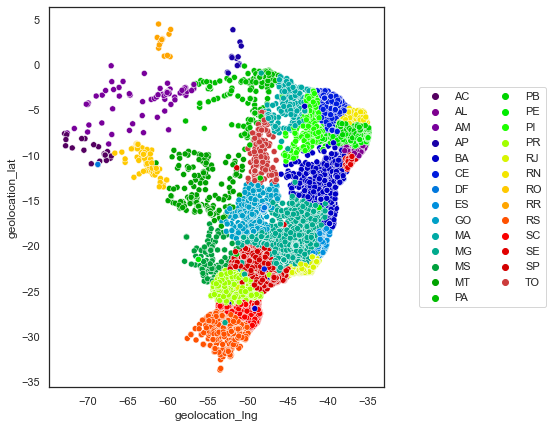

In [21]:
hue_order = sorted(geoloc['geolocation_state'].unique())
plt.figure(figsize=(6, 7))
sns.scatterplot(data=geoloc, x='geolocation_lng', y='geolocation_lat',
                hue='geolocation_state', hue_order=hue_order, palette='nipy_spectral')
plt.legend(bbox_to_anchor=(1.5, 0.5), loc=5, ncol=2)


## 2.4 Nettoyage des données


# 3. Analyse Exploratoire


## 3.1 Données numériques


## 3.2 Données catégoriques


## 3.3 Associations entre variables catégoriques et numériques


# 4. Feature Engineering


## 4.1 Nouvelles 'features' catégoriques


## 4.2 Nouvelles 'features' numériques


## 4.3 Pipeline de Feature Engineering


# 5. Enregistrement des données nettoyées


## 5.1 Sommaire des données nettoyées
